In [1]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
%matplotlib inline

import pandas as pd
from scipy.optimize import curve_fit

import json

def correlation_function(cov):
    p = cov[0]
    return (cov-p**2)/(p-p**2)

def straight_line_at_origin(porosity):
    def func(x, a):
        return a * x + porosity
    return func

In [4]:
#strings to output and input locations
beadpack_dic = {
    "out_direc": "../../../analysis/covariance/beadpack/",
    "seed_min": 43,
    "seed_max": 64,
    "tisize": 128
}

data_dic = beadpack_dic
out_direc = data_dic["out_direc"]

## Data Loading and Computation of radial averages

We load the two-point probability function data and perform radial averaging as well as normalizing to the correlation function.

$$ \kappa(r)=\frac{S^{(i)}_2(r)-\phi_{(i)}^2}{\phi_{(i)}-\phi_{(i)}^2}$$

In [5]:
orig_cov_pph = pd.read_csv(out_direc+"orig_pph.csv")
orig_cov_gph = pd.read_csv(out_direc+"orig_gph.csv")

radial_avg_orig_pph = np.mean(orig_cov_pph.values.T, axis=0)
radial_avg_orig_gph = np.mean(orig_cov_gph.values.T, axis=0)

print radial_avg_orig_pph.shape

correlation_func_orig = correlation_function(radial_avg_orig_pph)

(500L,)


We compute the slope of the correlation function at the origin for visualisation purposes only.

In [6]:
N = 5
slope_orig_corr, slope_orig_corr_cov = curve_fit(straight_line_at_origin(correlation_func_orig[0]), range(0, N), correlation_func_orig[0:N])
print slope_orig_corr

slope_radial_orig, sloper_radial_orig_cov = curve_fit(straight_line_at_origin(radial_avg_orig_pph[0]), range(0, N), radial_avg_orig_pph[0:N])
print slope_radial_orig

[-0.07707962]
[-0.01781375]


## Data Loading Synthetic Samples and Processing

We perform the same computations for the synthetic samples and also compute the mean and standard deviation at  
each lag distance $r$ to show the validity of our matched models.

In [33]:
cov_data = None
with open(out_direc+"covariance_data.json", "r") as f:
    cov_data = json.load(f)

chord_lengths_gphs = []
chord_lengths_pphs = []

orig_chord_length_gphs, orig_chord_length_pphs = None, None

for key in cov_data.keys():
    if key == 'orig':
        orig_chord_length_pphs = cov_data[key]['chord_length_pph']
        orig_chord_length_gphs = cov_data[key]['chord_length_gph']
    else:
        chord_lengths_pphs.append(cov_data[key]['chord_length_pph'])
        chord_lengths_gphs.append(cov_data[key]['chord_length_gph'])
        
avg_chord_length_gphs = np.mean(chord_lengths_gphs)
avg_chord_length_pphs = np.mean(chord_lengths_pphs)
print orig_chord_length_pphs, orig_chord_length_gphs
print avg_chord_length_pphs, avg_chord_length_gphs

20.352445383 35.8615397698
20.7186048545 35.302006195


In [9]:
cov_pphs = []
cov_gphs = []
for i in range(data_dic["seed_min"], data_dic["seed_max"]):
    cov_pph = pd.read_csv(out_direc+"S_"+str(i)+"_pph.csv")
    cov_gph = pd.read_csv(out_direc+"S_"+str(i)+"_gph.csv")
    cov_pphs.append(cov_pph.values.T)
    cov_gphs.append(cov_gph.values.T)
    
cov_pphs = np.array(cov_pphs)
cov_gphs = np.array(cov_gphs)
print cov_pphs.shape

directional_averages_pph = np.mean(cov_pphs, axis=0)
directional_averages_gph = np.mean(cov_gphs, axis=0)

radial_averages_pph = np.mean(cov_pphs.reshape(-1, cov_pphs.shape[-1]), axis=0)
radial_std_pph = np.std(cov_pphs.reshape(-1, cov_pphs.shape[-1]), axis=0)
slope_radial_pph, slope_radial_pph_cov = curve_fit(straight_line_at_origin(radial_averages_pph[0]), range(0, N), radial_averages_pph[0:N])

directional_std_pph = np.std(cov_pphs, axis=0)
directional_std_gph = np.std(cov_gphs, axis=0)

radial_averaged_corr = np.mean( [correlation_function(cov) for cov in cov_pphs.reshape(-1, cov_pphs.shape[-1])], axis=0)
radial_std_corr = np.std([correlation_function(cov) for cov in cov_pphs.reshape(-1, cov_pphs.shape[-1])], axis=0)

slope_synth_corr, slope_synth_corr_cov = curve_fit(straight_line_at_origin(radial_averaged_corr[0]), range(0, N), radial_averaged_corr[0:N])

directional_x = np.array([correlation_function(cov) for cov in cov_pphs[:, 0, :]])
directional_y = np.array([correlation_function(cov) for cov in cov_pphs[:, 1, :]])
directional_z = np.array([correlation_function(cov) for cov in cov_pphs[:, 2, :]])

directional_averages_normalized = np.zeros((3, directional_x.shape[1]))
directional_std_normalized = np.zeros((3, directional_x.shape[1]))

directional_averages_normalized[0] = np.mean(directional_x, axis=0)
directional_averages_normalized[1] = np.mean(directional_y, axis=0)
directional_averages_normalized[2] = np.mean(directional_z, axis=0)

directional_std_normalized[0] = np.std(directional_x, axis=0)
directional_std_normalized[1] = np.std(directional_y, axis=0)
directional_std_normalized[2] = np.std(directional_z, axis=0)

orig_normalized = np.array([correlation_function(cov) for cov in orig_cov_pph.values.T])

(21L, 3L, 200L)


In [10]:
porosity_avg = np.mean(cov_pphs[:, :, 0])
porosity_std = np.std(cov_pphs[:, :, 0])
print porosity_avg, porosity_std

porosity_orig_avg = np.mean(orig_cov_pph.values.T[:, 0])
porosity_orig_std= np.std(orig_cov_pph.values.T[:, 0])
print porosity_orig_avg

0.368620702381 0.00748255360917
0.3625534


## Directional Two-Point Probability Function Pore Phase including errorbars

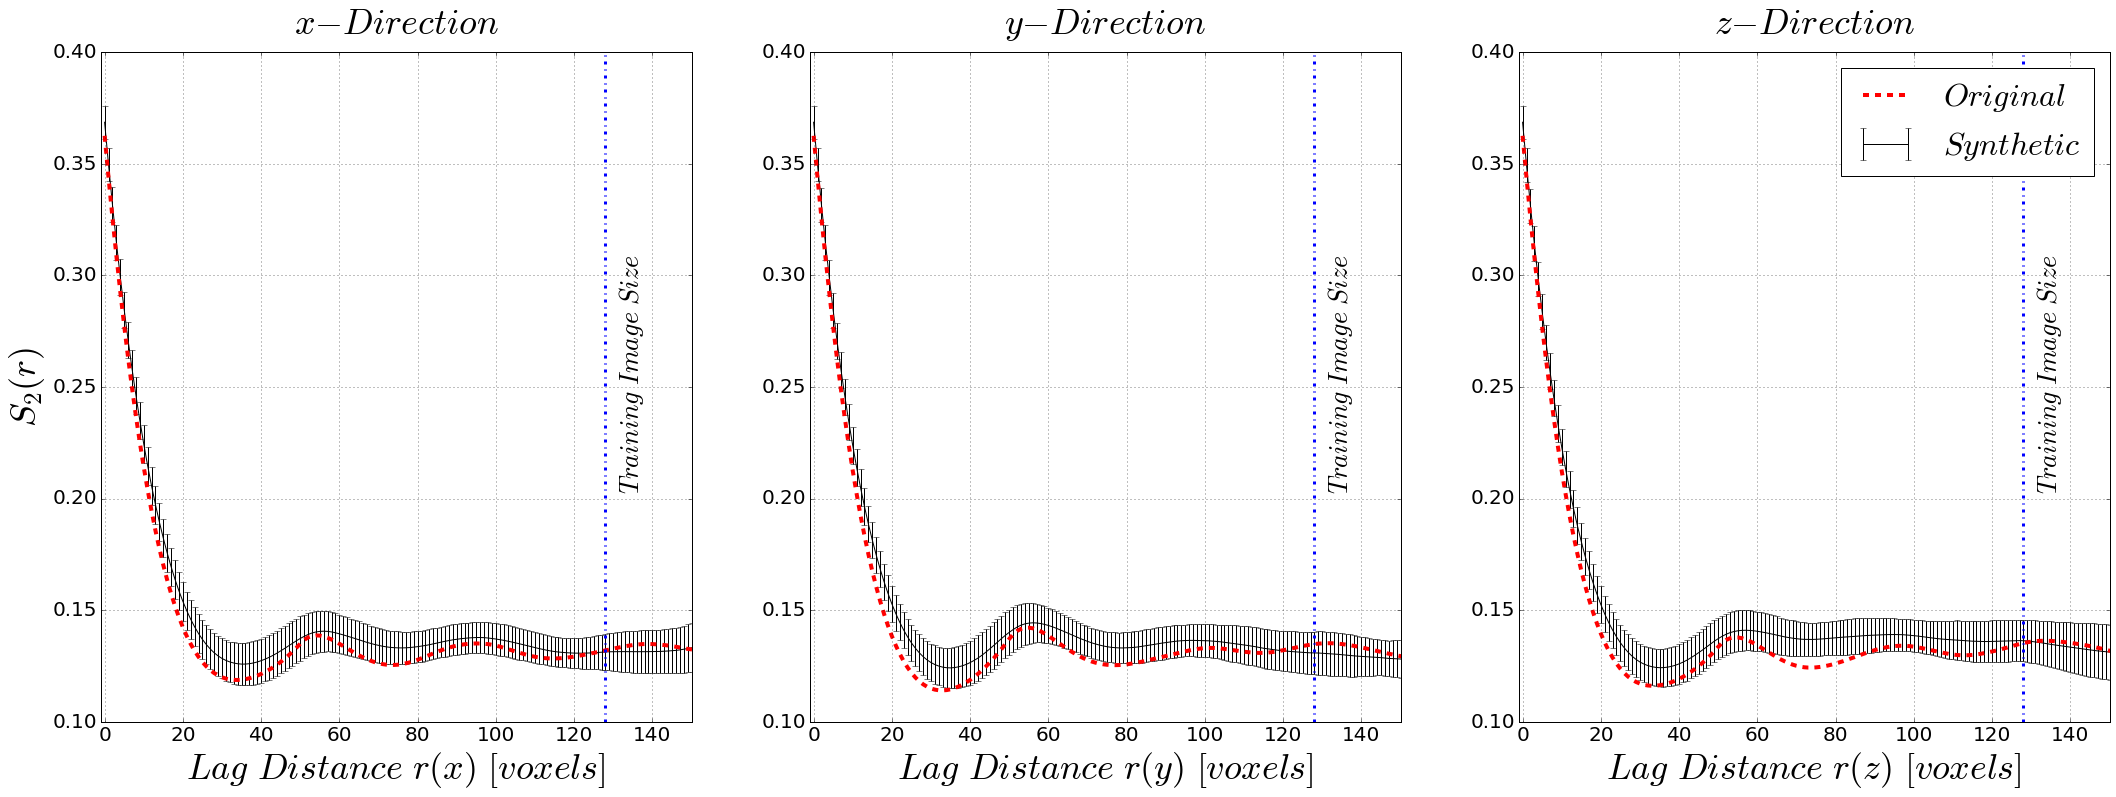

In [103]:
fig, ax = plt.subplots(1, 3, figsize=(36, 12))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.05)
for i, (j, direc) in zip(range(0, 6, 2), enumerate([r"$x$", r"$y$", r"$z$"])):    
    if j == 2:
        ax[j].errorbar(range(len(directional_averages_pph[j])), directional_averages_pph[j], yerr=directional_std_pph[j], c="black", fmt='-', label=r"$Synthetic$")
        ax[j].plot(range(len(orig_cov_pph.values.T[j])), orig_cov_pph.values.T[j], linestyle="--", linewidth=4, c="red", label=r"$Original$")
        ax[j].axvline(data_dic["tisize"], color="blue", linestyle="-.", linewidth=3)
        ax[j].text(data_dic["tisize"]+3., 0.3,r'$Training \ Image \ Size$',rotation=90, fontsize=26)
        ax[j].legend(fontsize=32)
    else:
        ax[j].errorbar(range(len(directional_averages_pph[j])), directional_averages_pph[j], yerr=directional_std_pph[j], c="black", fmt='-')
        ax[j].plot(range(len(orig_cov_pph.values.T[j])), orig_cov_pph.values.T[j], linestyle="--", linewidth=4, c="red")
        ax[j].axvline(data_dic["tisize"], color="blue", linestyle="-.", linewidth=3)
        ax[j].text(data_dic["tisize"]+3., 0.3,r'$Training \ Image \ Size$',rotation=90, fontsize=26)
        
    for tick in ax[j].xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    
    for tick in ax[j].yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    
for j, direc in enumerate([r"$x$", r"$y$", r"$z$"]):
    ax[j].set_title(direc+r"$-Direction$", fontsize=36, y=1.02) 
    ax[j].set_xlabel(r"$Lag \ Distance \ r($"+direc+"$) \ [voxels]$", fontsize=36) 

#ax[0].set_ylabel(r"$Two-Point \ Probability \ Function \ S_2(r)$", fontsize=34)
ax[0].set_ylabel(r"$S_2(r)$", fontsize=36) 
for ax_handle in ax.flatten():
    ax_handle.set_xlim(-1, 150)
    ax_handle.grid()
    
fig.savefig("../../../paper/figures/beadpack_directional_s2_porephase.png", bbox_extra_artists=None, bbox_inches='tight',dpi=72)

## Directional Correlation Function

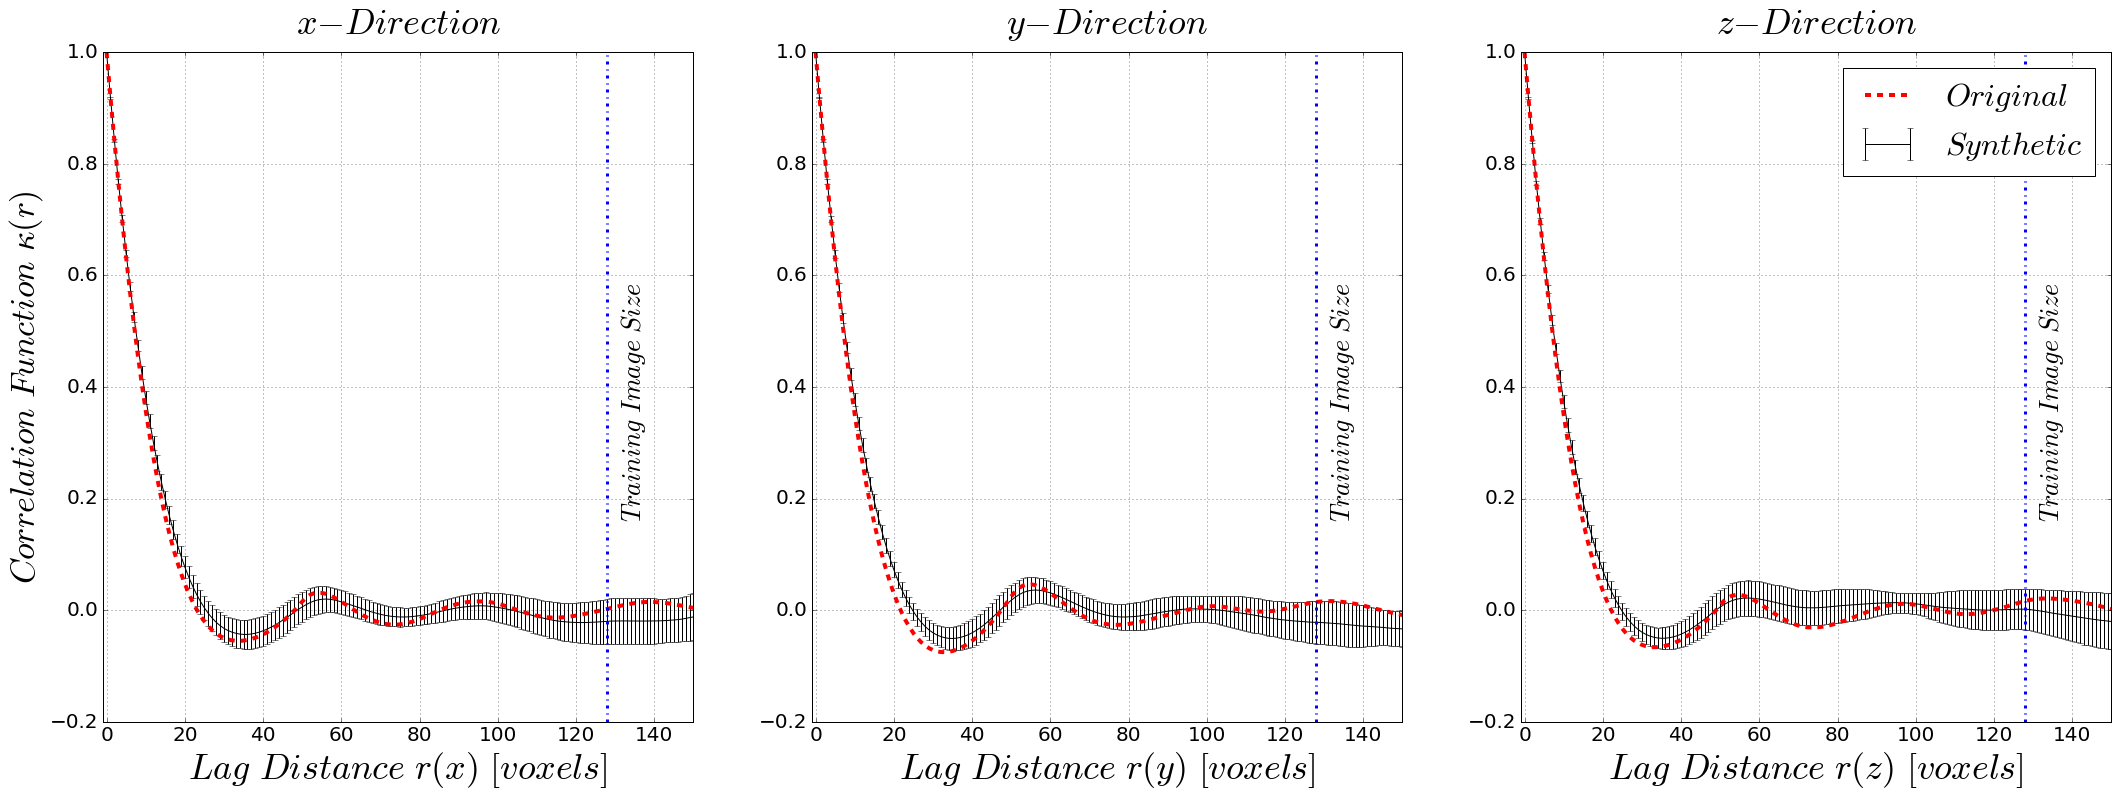

In [96]:
fig, ax = plt.subplots(1, 3, figsize=(36, 12))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.05)
for i, (j, direc) in zip(range(0, 6, 2), enumerate([r"$x$", r"$y$", r"$z$"])):    
    if j == 2:
        ax[j].errorbar(range(len(directional_averages_normalized[j])), directional_averages_normalized[j], yerr=directional_std_normalized[j], c="black", fmt='-', label=r"$Synthetic$")
        ax[j].plot(range(len(orig_normalized[j])), orig_normalized[j], linestyle="--", linewidth=4, c="red", label=r"$Original$")
        ax[j].axvline(data_dic["tisize"], color="blue", linestyle="-.", linewidth=3)
        ax[j].text(data_dic["tisize"]+3., 0.55,r'$Training \ Image \ Size$',rotation=90, fontsize=26)
        ax[j].legend(fontsize=32)
    else:
        ax[j].errorbar(range(len(directional_averages_normalized[j])), directional_averages_normalized[j], yerr=directional_std_normalized[j], c="black", fmt='-')
        ax[j].plot(range(len(orig_normalized[j])), orig_normalized[j], linestyle="--", linewidth=4, c="red")
        ax[j].axvline(data_dic["tisize"], color="blue", linestyle="-.", linewidth=3)
        ax[j].text(data_dic["tisize"]+3., 0.55,r'$Training \ Image \ Size$',rotation=90, fontsize=26)
        
    for tick in ax[j].xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    
    for tick in ax[j].yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    
for j, direc in enumerate([r"$x$", r"$y$", r"$z$"]):
    ax[j].set_title(direc+r"$-Direction$", fontsize=36, y=1.02) 
    ax[j].set_xlabel(r"$Lag \ Distance \ r($"+direc+"$) \ [voxels]$", fontsize=36) 

ax[0].set_ylabel(r"$Correlation \ Function \ \kappa(r)$", fontsize=34)   
for ax_handle in ax.flatten():
    ax_handle.set_xlim(-1, 150)
    ax_handle.grid()

## Correlation Function Plot and Chord Size

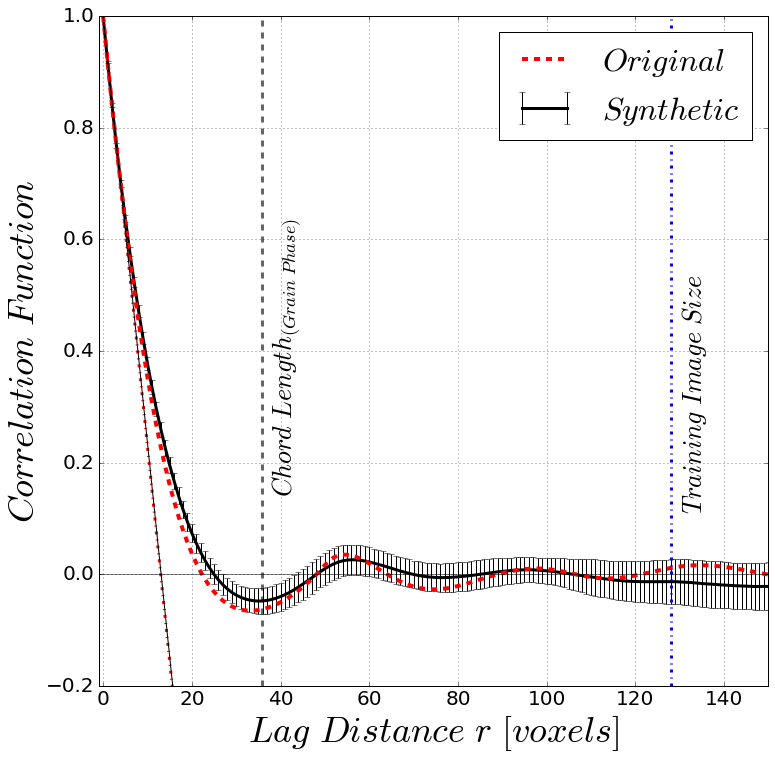

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

ax.errorbar(range(len(radial_averaged_corr)), radial_averaged_corr, yerr=radial_std_corr, c="black", elinewidth=1, fmt='-', label=r"$Synthetic$", linewidth=3)
ax.plot(range(len(correlation_func_orig)), correlation_func_orig, linestyle="--", linewidth=4, c="red", label=r"$Original$")

slope_range = np.array(range(0, 20, 1))
ax.plot(slope_range, slope_range*float(slope_orig_corr)+1., linestyle="-.", color="red", linewidth=3)
ax.plot(slope_range, slope_range*float(slope_synth_corr)+1., linestyle="-", color="black", linewidth=1)

ax.axvline(data_dic["tisize"], color="blue", linestyle="-.", linewidth=3)
ax.text(data_dic["tisize"]+2., 0.5, r'$Training \ Image \ Size$',rotation=90, fontsize=26)


ax.axvline(orig_chord_length, color="black", linestyle="--", linewidth=3, alpha=0.6)
ax.text(orig_chord_length+2., 0.6, r'$Chord \ Length_{(Grain \ Phase)}$',rotation=90, fontsize=26)

ax.axhline(0.0, linestyle="-", color="black", alpha=0.5)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

ax.set_xlabel(r"$Lag \ Distance \ r \ [voxels]$", fontsize=36) 

ax.set_ylabel(r"$Correlation \ Function$", fontsize=36)    
ax.set_xlim(-1, 150)
ax.set_ylim(-0.2, 1.0)
ax.grid()  
ax.legend(fontsize=32) 

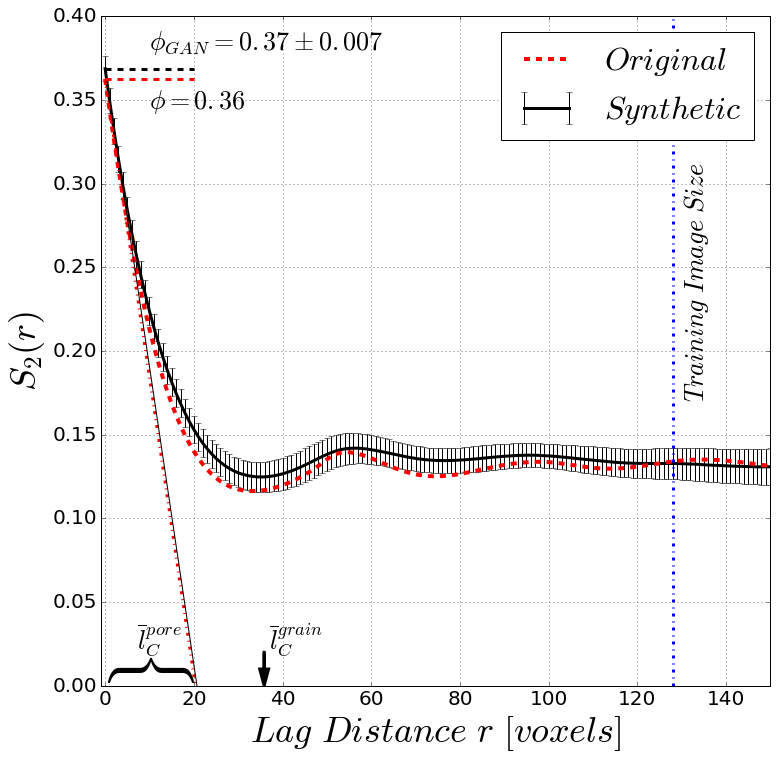

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

ax.errorbar(range(len(radial_averages_pph)), radial_averages_pph, yerr=radial_std_pph, c="black", elinewidth=1, fmt='-', label=r"$Synthetic$", linewidth=3)
ax.plot(range(len(radial_avg_orig_pph)), radial_avg_orig_pph, linestyle="--", linewidth=4, c="red", label=r"$Original$")

slope_range = np.array(range(0, 30, 1))
ax.plot(slope_range, slope_range*float(slope_radial_orig)+radial_avg_orig_pph[0], linestyle="-.", color="red", linewidth=3)
ax.plot(slope_range, slope_range*float(slope_radial_pph)+radial_averages_pph[0], linestyle="-", color="black", linewidth=1)

ax.plot([0, 20], [porosity_avg, porosity_avg], linestyle="--", color="black", linewidth=3)
ax.text(10, 0.38, r'$\phi_{GAN}=%.2f \pm %.3f$' % (porosity_avg, porosity_std),rotation=0, fontsize=26)

ax.plot([0, 20], [porosity_orig_avg, porosity_orig_avg], linestyle="--", color="red", linewidth=3)
ax.text(10, 0.345, r'$\phi=%.2f$' % porosity_orig_avg, rotation=0, fontsize=26)

ax.axvline(data_dic["tisize"], color="blue", linestyle="-.", linewidth=3)
ax.text(data_dic["tisize"]+2., 0.3, r'$Training \ Image \ Size$',rotation=90, fontsize=26)

ax.axhline(0.0, linestyle="-", color="black", alpha=0.5)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

ax.set_xlabel(r"$Lag \ Distance \ r \ [voxels]$", fontsize=36) 

ax.text(0, -0.02, r'$\{$', rotation=-90, fontsize=70)
ax.text(orig_chord_length_pphs/2.-3, 0.022, r'$\overline{l}_C^{pore}$',rotation=0, fontsize=26)

ax.arrow(orig_chord_length_gphs, 0.02, 0, -0.01, head_width=2, head_length=0.01, fc='k', ec='k', linewidth=3)
ax.text(orig_chord_length_gphs+1., 0.022, r'$\overline{l}_C^{grain}$',rotation=0, fontsize=26)

#ax.set_ylabel(r"$Two-Point \ Probability \ Function \ S_2(r)$", fontsize=36)    
ax.set_ylabel(r"$S_2(r)$", fontsize=36)    
ax.set_xlim(-1, 150)
ax.set_ylim(0.0, 0.4)

ax.grid()  
ax.legend(fontsize=32) 

fig.savefig("../../../paper/figures/beadpack_radial_averaged_s2.png", bbox_extra_artists=None, bbox_inches='tight',dpi=72)